# Sports Apparel Stock Analysis and Forecasting

In [1]:
#Importing all the required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import warnings
from fredapi import Fred
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import yfinance as yf
import seaborn as sns; sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
yf.pdr_override() 
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
symbols = ["NKE", "LULU", "UAA", "COLM", "SKX", "^GSPC"]

# Defining the date range from Jan 2023 to Oct 2023
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 10, 31)

stock_price = yf.download(symbols, start=start_date, end=end_date, interval='1d')['Close']

[*********************100%%**********************]  6 of 6 completed


In [3]:
stock_price.head()

,COLM,LULU,NKE,SKX,UAA,^GSPC
Date,,,,,,
2023-01-03,88.610001,323.380005,118.750000,41.830002,10.09,3824.139893
2023-01-04,91.430000,320.980011,121.209999,43.450001,10.67,3852.969971
2023-01-05,90.220001,325.929993,120.620003,43.220001,10.34,3808.100098
2023-01-06,92.709999,329.260010,124.529999,44.590000,10.75,3895.080078
2023-01-09,92.260002,298.660004,124.849998,45.779999,10.66,3892.090088


In [4]:
stock_price.isnull().sum()

COLM     0
LULU     0
NKE      0
SKX      0
UAA      0
^GSPC    0
dtype: int64

## CAMP

It is a financial model that calculates the expected return on investment by considering the risk-free rate of return, the investment's beta (systematic risk), and the expected market return. It provides a way to determine whether an investment is decently compensated for its risk level.

In [5]:
# Importing the FRED API Key
fred = Fred(api_key='d101abc7303a47ef5255f26765d2efdd')
fred.search('DGS3MO')

,frequency,frequency_short,id,last_updated,notes,observation_end,observation_start,popularity,realtime_end,realtime_start,seasonal_adjustment,seasonal_adjustment_short,title,units,units_short
series id,,,,,,,,,,,,,,,
DGS3MO,Daily,D,DGS3MO,2023-11-03 15:23:10-05:00,For further information regarding treasury con...,2023-11-02,1981-09-01,73,2023-11-06,2023-11-06,Not Seasonally Adjusted,NSA,Market Yield on U.S. Treasury Securities at 3-...,Percent,%


In [6]:
risk_free = fred.get_series('DGS3MO')
risk_free

1981-09-01    17.01
1981-09-02    16.65
1981-09-03    16.96
1981-09-04    16.64
1981-09-07      NaN
              ...  
2023-10-27     5.59
2023-10-30     5.60
2023-10-31     5.59
2023-11-01     5.57
2023-11-02     5.54
Length: 11003, dtype: float64

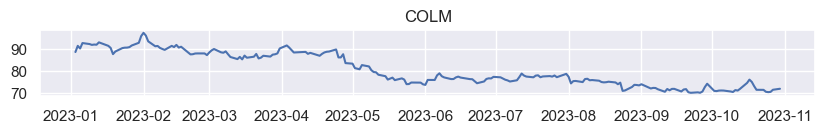

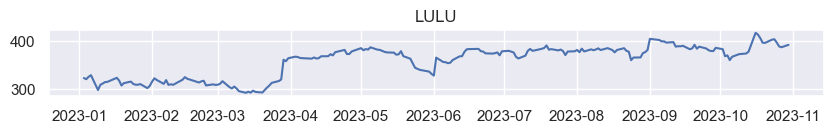

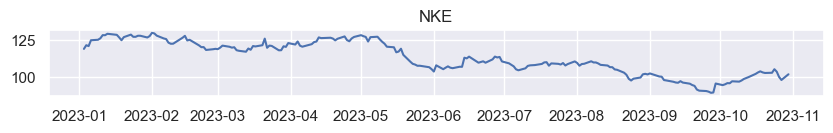

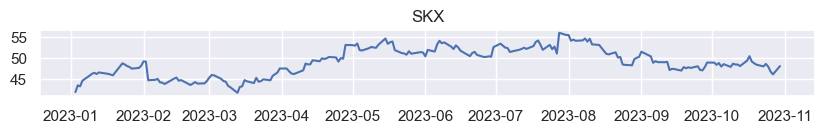

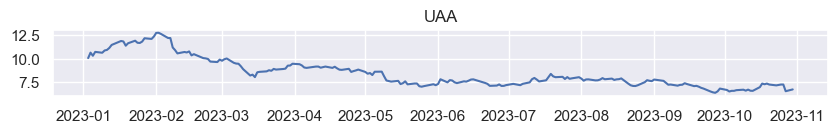

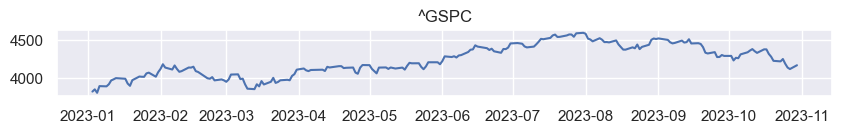

In [7]:
for i, symbols in enumerate(stock_price.columns, start=1):
    plt.figure(figsize=(10, 6))
    plt.subplot(6, 1, i)
    plt.plot(stock_price[symbols])
    plt.title(f'{symbols}')
    plt.show()

In [8]:
stock_price.corr()

,COLM,LULU,NKE,SKX,UAA,^GSPC
COLM,1.000000,-0.743533,0.908860,-0.512552,0.913191,-0.733403
LULU,-0.743533,1.000000,-0.594610,0.679654,-0.720480,0.762999
NKE,0.908860,-0.594610,1.000000,-0.261763,0.808398,-0.680331
SKX,-0.512552,0.679654,-0.261763,1.000000,-0.484499,0.700027
UAA,0.913191,-0.720480,0.808398,-0.484499,1.000000,-0.614675
^GSPC,-0.733403,0.762999,-0.680331,0.700027,-0.614675,1.000000


<Axes: >

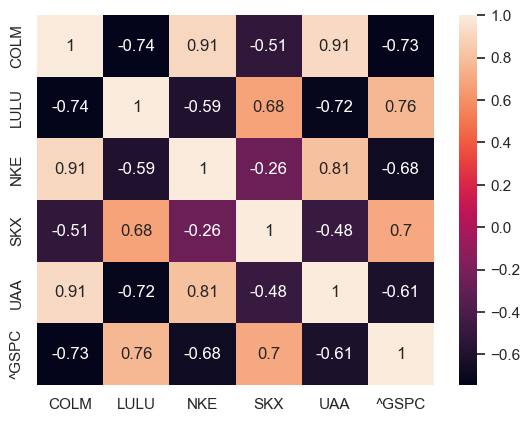

In [9]:
sns.heatmap(stock_price.corr(),annot=True)

In [10]:
returns = stock_price.pct_change()
returns.dropna(inplace=True)
returns.head()

,COLM,LULU,NKE,SKX,UAA,^GSPC
Date,,,,,,
2023-01-04,0.031825,-0.007422,0.020716,0.038728,0.057483,0.007539
2023-01-05,-0.013234,0.015421,-0.004868,-0.005293,-0.030928,-0.011646
2023-01-06,0.027599,0.010217,0.032416,0.031698,0.039652,0.022841
2023-01-09,-0.004854,-0.092936,0.002570,0.026688,-0.008372,-0.000768
2023-01-10,-0.004119,0.036229,0.007929,0.009611,0.022514,0.006978


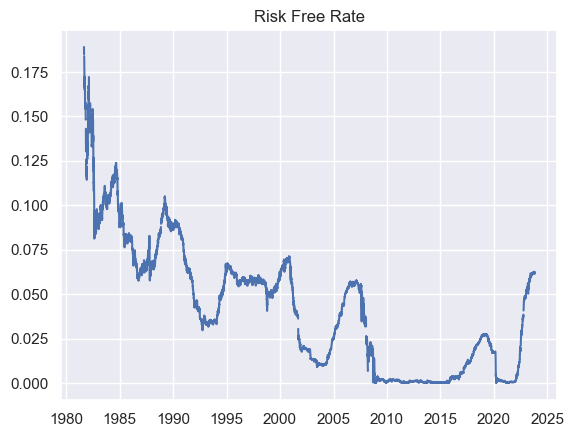

In [11]:
risk_free = risk_free/90
plt.plot(risk_free)
plt.title('Risk Free Rate')
plt.show()

In [12]:
symbols = stock_price.columns
risk_free = 0.1
for i in symbols:
    returns[f'excess_return_{i}'] = returns[i] - risk_free

In [13]:
y_nke = returns['excess_return_NKE']
X_nke = returns['excess_return_^GSPC']

In [14]:
X_nke = sm.add_constant(X_nke, prepend=False)
capm_nke = sm.OLS(y_nke, X_nke)
camp_result_nke = capm_nke.fit()
camp_result_nke.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      excess_return_NKE   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     84.35
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           4.64e-17
Time:                        12:53:43   Log-Likelihood:                 604.84
No. Observations:                 207   AIC:                            -1206.
Df Residuals:                     205   BIC:                            -1199.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
excess_return_^GSPC     0.9847      0.107      9.184      0.000       0.773       1.196
const                  -0.0026      0.011     -0.242      0.809      -0.024       0.019
==============================================================================
Omnibus:                       47.361   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.266
Skew:                           0.685   Prob(JB):                     1.02e-60
Kurtosis:                       8.491   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
y_lulu = returns['excess_return_LULU']
X_lulu = returns['excess_return_^GSPC']

In [16]:
X_lulu = sm.add_constant(X_lulu, prepend=False)
capm_lulu = sm.OLS(y_lulu, X_lulu)
camp_result_lulu = capm_lulu.fit()
camp_result_lulu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     excess_return_LULU   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     66.31
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           3.71e-14
Time:                        12:53:43   Log-Likelihood:                 533.16
No. Observations:                 207   AIC:                            -1062.
Df Residuals:                     205   BIC:                            -1056.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
excess_return_^GSPC     1.2344      0.152      8.143      0.000       0.935       1.533
const                   0.0240      0.015      1.586      0.114      -0.006       0.054
==============================================================================
Omnibus:                      111.441   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1579.213
Skew:                           1.680   Prob(JB):                         0.00
Kurtosis:                      16.108   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
y_uaa = returns['excess_return_UAA']
X_uaa = returns['excess_return_^GSPC']

In [18]:
X_uaa = sm.add_constant(X_uaa, prepend=False)
capm_uaa = sm.OLS(y_uaa, X_uaa)
camp_result_uaa = capm_uaa.fit()
camp_result_uaa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      excess_return_UAA   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     67.64
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           2.24e-14
Time:                        12:53:43   Log-Likelihood:                 495.48
No. Observations:                 207   AIC:                            -987.0
Df Residuals:                     205   BIC:                            -980.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
excess_return_^GSPC     1.4955      0.182      8.224      0.000       1.137       1.854
const                   0.0473      0.018      2.602      0.010       0.011       0.083
==============================================================================
Omnibus:                       24.350   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.584
Skew:                          -0.619   Prob(JB):                     3.44e-10
Kurtosis:                       4.877   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
y_colm = returns['excess_return_COLM']
X_colm = returns['excess_return_^GSPC']

In [20]:
X_colm = sm.add_constant(X_colm, prepend=False)
capm_colm = sm.OLS(y_colm, X_colm)
camp_result_colm = capm_colm.fit()
camp_result_colm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     excess_return_COLM   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     77.01
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           6.67e-16
Time:                        12:53:43   Log-Likelihood:                 615.88
No. Observations:                 207   AIC:                            -1228.
Df Residuals:                     205   BIC:                            -1221.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
excess_return_^GSPC     0.8920      0.102      8.776      0.000       0.692       1.092
const                  -0.0121      0.010     -1.193      0.234      -0.032       0.008
==============================================================================
Omnibus:                       18.615   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.717
Skew:                          -0.506   Prob(JB):                     2.14e-07
Kurtosis:                       4.593   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
y_skx = returns['excess_return_SKX']
X_skx = returns['excess_return_^GSPC']

In [22]:
X_skx = sm.add_constant(X_skx, prepend=False)
capm_skx = sm.OLS(y_skx, X_skx)
camp_result_skx = capm_skx.fit()
camp_result_skx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      excess_return_SKX   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     63.91
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           9.37e-14
Time:                        12:53:43   Log-Likelihood:                 553.12
No. Observations:                 207   AIC:                            -1102.
Df Residuals:                     205   BIC:                            -1096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
excess_return_^GSPC     1.1003      0.138      7.994      0.000       0.829       1.372
const                   0.0104      0.014      0.756      0.451      -0.017       0.038
==============================================================================
Omnibus:                       34.220   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.313
Skew:                           0.278   Prob(JB):                     7.99e-52
Kurtosis:                       8.194   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
camp_result_nke.params[0]

0.9847220501700142

In [24]:
camp_result_lulu.params[0]

1.2343515225140491

In [25]:
camp_result_colm.params[0]

0.8920000910591143

In [26]:
camp_result_uaa.params[0]

1.4954602487866926

In [27]:
camp_result_skx.params[0]

1.1003434342981777

In [28]:
def SML(rf, ret, beta):
    asset_ret = [rf+(rm-rf)*i for i in betas]
    plt.plot(betas, asset_ret)
    plt.xlabel('Asset Beta')
    plt.ylabel('Asset Return')
    plt.title('SML')
    plt.plot(1, ret, 'ro')

In [29]:
betas = [camp_result_nke.params[0], camp_result_lulu.params[0], camp_result_colm.params[0], camp_result_uaa.params[0], camp_result_skx.params[0]]
rm = returns['^GSPC'].mean()
risk_free_mean = 0.0001

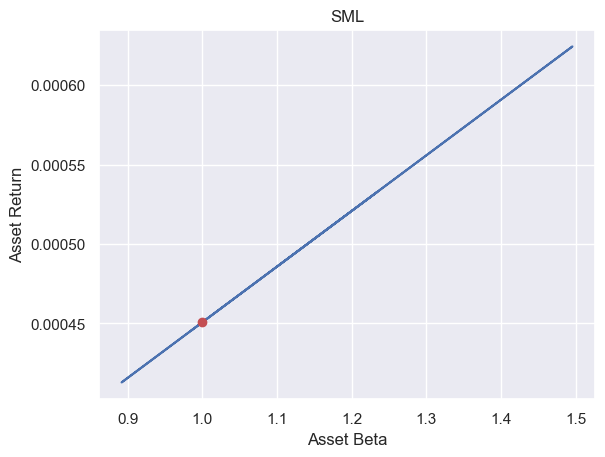

In [30]:
SML(risk_free_mean, rm, betas)

In [31]:
betas = [camp_result_nke.params[0], camp_result_lulu.params[0], camp_result_colm.params[0], camp_result_uaa.params[0], camp_result_skx.params[0]
]
ret_exp = [0.1, 0.09,0.11, 0.12, 0.13]

# Create DataFrames for beta values and expected returns
df_betas = pd.DataFrame(betas, columns=['betas'])
df_ret_exp = pd.DataFrame(ret_exp, columns=['ret_exp'])

# Combine both DataFrames horizontally (side by side)
df_all = pd.concat([df_betas, df_ret_exp], axis=1)

# Set column names and index
df_all.index = ['NKE', 'LULU', 'COLM', 'UAA', 'SKX']
df_all.columns = ['betas', 'ret_exp']

# Display the resulting DataFrame
print(df_all)

         betas  ret_exp
NKE   0.984722     0.10
LULU  1.234352     0.09
COLM  0.892000     0.11
UAA   1.495460     0.12
SKX   1.100343     0.13


In [32]:
def over_under_val(rf, rm, stock):
    x = rf + (rm-rf)*df_all['betas'].loc[stock]
    y = df_all['ret_exp'].loc[stock]
    if x<y:
        print('The stock is undervalued')
    elif x > y:
        print('The stock is overvalued')
    else:
        print('The stock is fairly priced')

In [33]:
over_under_val(risk_free_mean, rm,'NKE')

The stock is undervalued


In [34]:
over_under_val(risk_free_mean, rm,'LULU')

The stock is undervalued


In [35]:
over_under_val(risk_free_mean, rm,'COLM')

The stock is undervalued


In [36]:
over_under_val(risk_free_mean, rm,'UAA')

The stock is undervalued


In [37]:
over_under_val(risk_free_mean, rm,'SKX')

The stock is undervalued


### Sharpe Ratio

It is a measure of the risk-adjusted return of an investment or portfolio. It quantifies how much excess return an investment generates for each unit of risk taken. The formula for the Sharpe ratio is as follows:

Sharpe Ratio = (Return of the Investment - Risk-Free Rate) / Standard Deviation of the Investment's Returns


In [38]:
def sharpe(symbols, rf, n_assets):
    sharpe_ratios = {}
    for i,j in zip(symbols, range(n_assets)):
        sharpe_ratios[i] = np.round((returns.iloc[:, j].mean() - rf) / np.std(returns.iloc[:,j]),2)
    return sharpe_ratios

In [39]:
n_assets = 5
sharpe(symbols, risk_free_mean, n_assets)

{'COLM': -0.07, 'LULU': 0.05, 'NKE': -0.05, 'SKX': 0.04, 'UAA': -0.07}

Investors prefer investments with higher positive Sharpe ratios as they offer better risk-adjusted returns.

So, from the above results we can say that LULU and SKX stocks have better performance when compared to others. 

### Treynor ratio

Treynor ratio is a valuable metric for evaluating the performance of a portfolio about its systematic risk exposure. It helps investors assess whether the portfolio is providing sufficient excess return given the level of market risk it bears.

In [40]:
def treynor(symbols, rf, n_assets):
    treynor_ratios = {}
    for i,j in zip(symbols, range(n_assets)):
        treynor_ratios[i] = np.round((returns.iloc[:, j].mean() - rf)\
                                     / (df_all['betas'].iloc[j]),4)
    return treynor_ratios

In [41]:
treynor(symbols, risk_free_mean, n_assets)

{'COLM': -0.001, 'LULU': 0.0008, 'NKE': -0.0008, 'SKX': 0.0005, 'UAA': -0.0016}

A higher Treynor ratio suggests better risk-adjusted performance, while a negative Treynor ratio may indicate that the portfolio is not generating sufficient excess return given its level of systematic risk.

From the results we can conclude that LULU and SKX are relatively better options in the portfolio, as they are delivering positive excess returns for their systematic risk

## Selecting stocks of LULU and SKX

## Moving Average

In [42]:
stocks_1 = ["LULU"]

# Defining the date range from Jan 2023 to OCT 2023
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 10, 31)

stock_price_lulu = yf.download(stocks_1, start=start_date, end=end_date, interval='1d')['Close']

[*********************100%%**********************]  1 of 1 completed


In [43]:
stock_price_lulu

Date
2023-01-03    323.380005
2023-01-04    320.980011
2023-01-05    325.929993
2023-01-06    329.260010
2023-01-09    298.660004
                 ...    
2023-10-24    403.369995
2023-10-25    396.700012
2023-10-26    388.619995
2023-10-27    386.820007
2023-10-30    391.750000
Name: Close, Length: 208, dtype: float64

In [44]:
#Spliting the data to training and testing data
diff_train_len_lulu = int(len(stock_price_lulu)*0.80)
diff_train_lulu = stock_price_lulu[:diff_train_len_lulu]
diff_test_lulu = stock_price_lulu[diff_train_len_lulu:]

In [45]:
start = len(diff_train_lulu)
end = len(diff_train_lulu) + len(diff_test_lulu) - 1

In [46]:
ma_model_lulu = ARIMA(diff_train_lulu, order =(0,0,8))
ma_result_lulu = ma_model_lulu.fit()

In [47]:
ma_pred_lulu = ma_result_lulu.predict(start, end)
ma_pred_lulu.index = diff_test_lulu.index

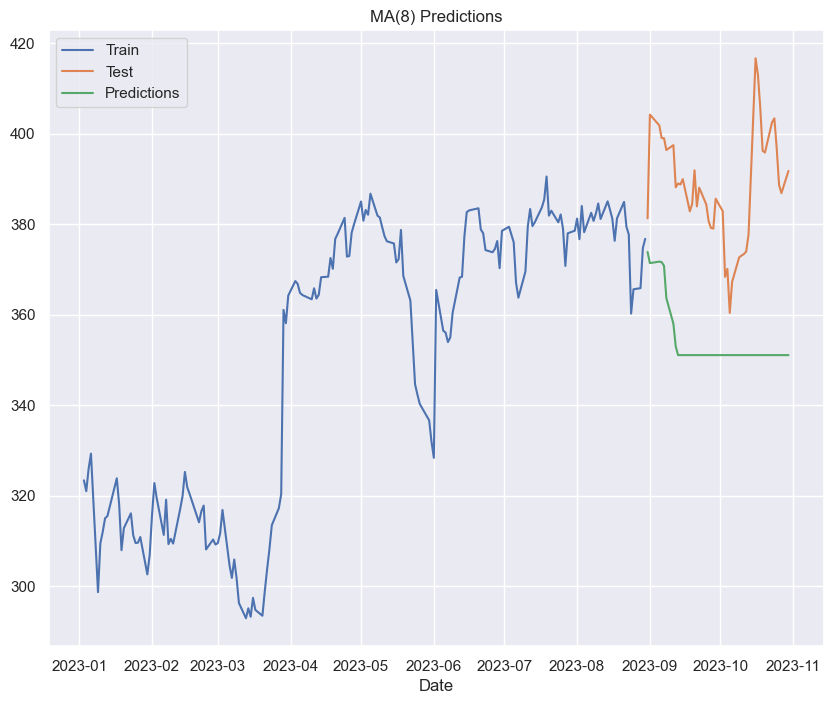

In [48]:
plt.figure(figsize=(10, 8))
plt.title('MA(8) Predictions')
plt.plot(diff_train_lulu, label='Train')
plt.plot(diff_test_lulu, label='Test')
plt.plot(ma_pred_lulu, label='Predictions')
plt.xlabel('Date')
plt.legend()
plt.show()

In [49]:
mae_ma_lulu = mean_absolute_error(diff_test_lulu, ma_pred_lulu)
mse_ma_lulu = mean_squared_error(diff_test_lulu, ma_pred_lulu)
rmse_ma_lulu = np.sqrt(mean_squared_error(diff_test_lulu, ma_pred_lulu))

In [50]:
print("Mean Absolute Error (MAE):", mae_ma_lulu)
print("Mean Squared Error (MSE):", mse_ma_lulu)
print("Root Mean Squared Error (RMSE):", rmse_ma_lulu)

Mean Absolute Error (MAE): 33.85134215578959
Mean Squared Error (MSE): 1297.3544437644437
Root Mean Squared Error (RMSE): 36.01880680650657


## Autoregressive Moving Average

In [51]:
arma_model_lulu  = ARIMA(diff_train_lulu, order = (8, 0, 8))
arma_result_lulu = arma_model_lulu.fit()

In [52]:
arma_pred_lulu = arma_result_lulu.predict(start, end)
arma_pred_lulu.index = diff_test_lulu.index

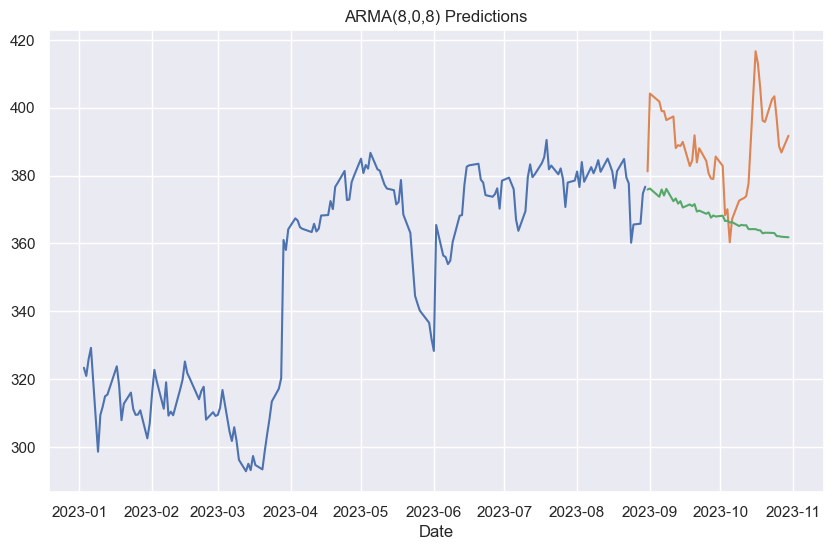

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(diff_train_lulu, label='Train')
plt.plot(diff_test_lulu, label='Test')
plt.plot(arma_pred_lulu, label='Prediction')
plt.title('ARMA(8,0,8) Predictions')
plt.xlabel('Date')
plt.show()

In [54]:
mae_arma_lulu = mean_absolute_error(diff_test_lulu, arma_pred_lulu)
mse_arma_lulu = mean_squared_error(diff_test_lulu, arma_pred_lulu)
rmse_arma_lulu = np.sqrt(mean_squared_error(diff_test_lulu, arma_pred_lulu))

In [55]:
print("Mean Absolute Error (MAE):", mae_arma_lulu)
print("Mean Squared Error (MSE):", mse_arma_lulu)
print("Root Mean Squared Error (RMSE):", rmse_arma_lulu)

Mean Absolute Error (MAE): 20.07176661316182
Mean Squared Error (MSE): 558.7507700058902
Root Mean Squared Error (RMSE): 23.637909594672077


## ARIMA

In [56]:
arima_model_lulu = ARIMA(diff_train_lulu, order=(8, 1, 8))
arima_result_lulu = arima_model_lulu.fit()

In [57]:
arima_pred_lulu = arima_result_lulu.predict(start, end)
arima_pred_lulu.index = diff_test_lulu.index

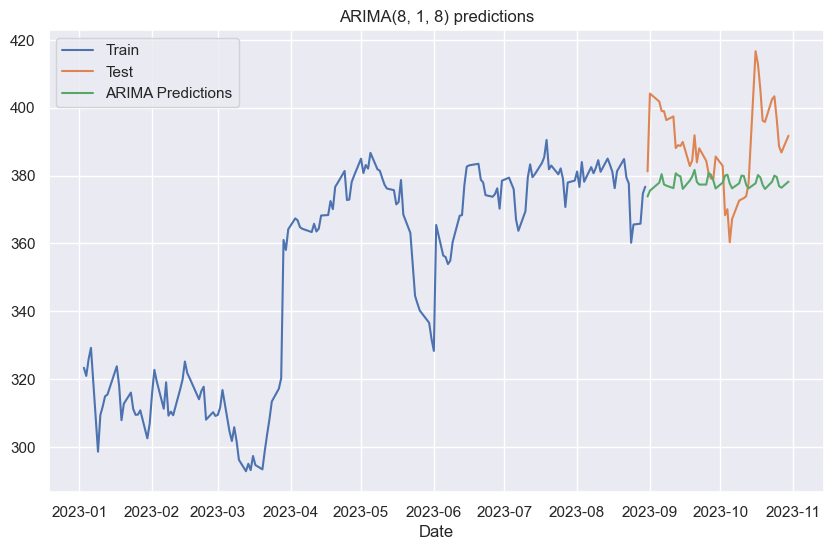

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(diff_train_lulu, label='Train')
plt.plot(diff_test_lulu, label='Test')
plt.plot(arima_pred_lulu, label='ARIMA Predictions')
plt.title('ARIMA(8, 1, 8) predictions')
plt.xlabel('Date')
plt.legend()
plt.show()

In [59]:
mae_arima_lulu = mean_absolute_error(diff_test_lulu, arima_pred_lulu)
mse_arima_lulu = mean_squared_error(diff_test_lulu, arima_pred_lulu)
rmse_arima_lulu = np.sqrt(mean_squared_error(diff_test_lulu, arima_pred_lulu))

In [60]:
print("Mean Absolute Error (MAE):", mae_arima_lulu)
print("Mean Squared Error (MSE):", mse_arima_lulu)
print("Root Mean Squared Error (RMSE):", rmse_arima_lulu)

Mean Absolute Error (MAE): 13.013412199210087
Mean Squared Error (MSE): 251.38668738751693
Root Mean Squared Error (RMSE): 15.855178566875773


## SARIMAX

In [61]:
stock_lulu = 'LULU'
start = datetime.datetime(2023, 1, 1)
end = datetime.datetime(2023, 10, 1)
stock_price_lulu = yf.download(stock_lulu, start=start, end=end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [62]:
stock_price_lulu

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,326.880005,327.339996,319.459991,323.380005,323.380005,1305000
2023-01-04,326.559998,326.750000,317.029999,320.980011,320.980011,1678100
2023-01-05,320.869995,328.540009,316.500000,325.929993,325.929993,1787000
2023-01-06,329.500000,334.230011,326.820007,329.260010,329.260010,2298200
2023-01-09,293.200012,304.410004,289.480011,298.660004,298.660004,8292900
...,...,...,...,...,...,...
2023-09-25,386.019989,387.500000,378.109985,384.329987,384.329987,1576700
2023-09-26,380.630005,384.720001,378.290009,380.660004,380.660004,1521100
2023-09-27,382.209991,384.290009,377.040009,379.140015,379.140015,700400


In [63]:
lulu_filtered = stock_price_lulu[['Open', 'High', 'Low', 'Volume']]
X = lulu_filtered
y = stock_price_lulu['Close']

In [64]:
train_len_lulu = int(len(stock_price_lulu) * 0.8)
X_train_lulu, y_train_lulu = X[:train_len_lulu], y[:train_len_lulu]
X_test_lulu, y_test_lulu = X[train_len_lulu:], y[train_len_lulu:]

In [65]:
sarimax = SARIMAX(y_train_lulu, exog=X_train_lulu, order=(8, 1, 8))
sarimax_results_lulu = sarimax.fit(disp=0)

In [66]:
start = len(X_train_lulu)
end = len(X_train_lulu) + len(X_test_lulu) -1

In [67]:
sarimax_pred_lulu = sarimax_results_lulu.predict(start, end, exog=X_test_lulu)
sarimax_pred_lulu.index = X_test_lulu.index

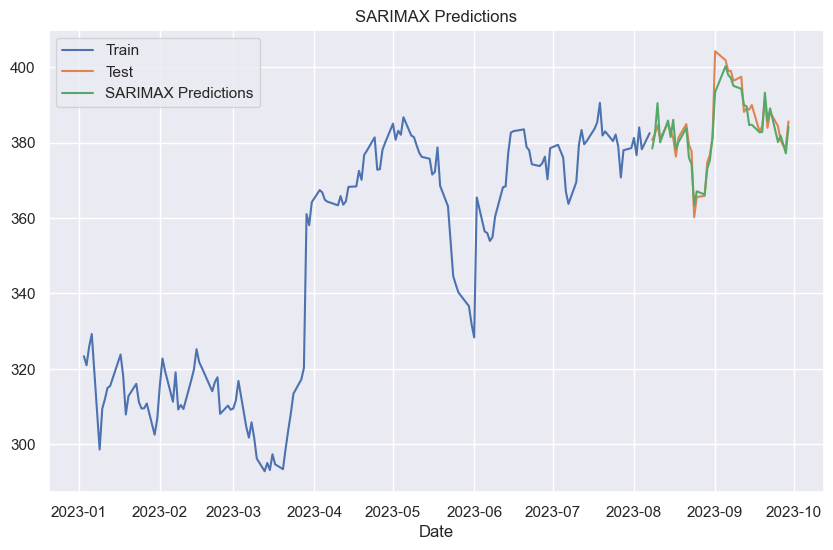

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(y_train_lulu, label='Train')
plt.plot(y_test_lulu, label='Test')
plt.plot(sarimax_pred_lulu, label='SARIMAX Predictions')
plt.title('SARIMAX Predictions')
plt.xlabel('Date')
plt.legend()
plt.show()

In [69]:
mae_sarimax_lulu = mean_absolute_error(y_test_lulu, sarimax_pred_lulu)
mse_sarimax_lulu = mean_squared_error(y_test_lulu, sarimax_pred_lulu)
rmse_sarimax_lulu = np.sqrt(mean_squared_error(y_test_lulu, sarimax_pred_lulu))

In [70]:
print("Mean Absolute Error (MAE):", mae_sarimax_lulu)
print("Mean Squared Error (MSE):", mse_sarimax_lulu)
print("Root Mean Squared Error (RMSE):", rmse_sarimax_lulu)

Mean Absolute Error (MAE): 2.1761818868850065
Mean Squared Error (MSE): 8.761249612383835
Root Mean Squared Error (RMSE): 2.959940812310921


In [71]:
print("Moving Average:")
print("Mean Absolute Error (MAE):", mae_ma_lulu)
print("Mean Squared Error (MSE):", mse_ma_lulu)
print("Root Mean Squared Error (RMSE):", rmse_ma_lulu)

print("Autoregression Moving Average:")
print("Mean Absolute Error (MAE):", mae_arma_lulu)
print("Mean Squared Error (MSE):", mse_arma_lulu)
print("Root Mean Squared Error (RMSE):", rmse_arma_lulu)

print("ARIMA:")
print("Mean Absolute Error (MAE):", mae_arima_lulu)
print("Mean Squared Error (MSE):", mse_arima_lulu)
print("Root Mean Squared Error (RMSE):", rmse_arima_lulu)

print("SARIMAX:")
print("Mean Absolute Error (MAE):", mae_sarimax_lulu)
print("Mean Squared Error (MSE):", mse_sarimax_lulu)
print("Root Mean Squared Error (RMSE):", rmse_sarimax_lulu)

Moving Average:
Mean Absolute Error (MAE): 33.85134215578959
Mean Squared Error (MSE): 1297.3544437644437
Root Mean Squared Error (RMSE): 36.01880680650657
Autoregression Moving Average:
Mean Absolute Error (MAE): 20.07176661316182
Mean Squared Error (MSE): 558.7507700058902
Root Mean Squared Error (RMSE): 23.637909594672077
ARIMA:
Mean Absolute Error (MAE): 13.013412199210087
Mean Squared Error (MSE): 251.38668738751693
Root Mean Squared Error (RMSE): 15.855178566875773
SARIMAX:
Mean Absolute Error (MAE): 2.1761818868850065
Mean Squared Error (MSE): 8.761249612383835
Root Mean Squared Error (RMSE): 2.959940812310921


### From the results we can say that SARIMAX gives the best performing model

## Using SARIMAX We will be forcasting the LULU and SKX Stocks

## LULU Forecasting

In [72]:
sarimax_model = SARIMAX(y, order=(8, 1, 8))
sarimax_result = sarimax_model.fit(disp=0)

In [73]:
sarimax_forecast_lulu = sarimax_result.forecast(steps=30, exog=X_test_lulu.iloc[-30:])
forecast_index_lulu = pd.date_range(y.index[-1], periods=30)
sarimax_forecast_lulu.index = forecast_index_lulu

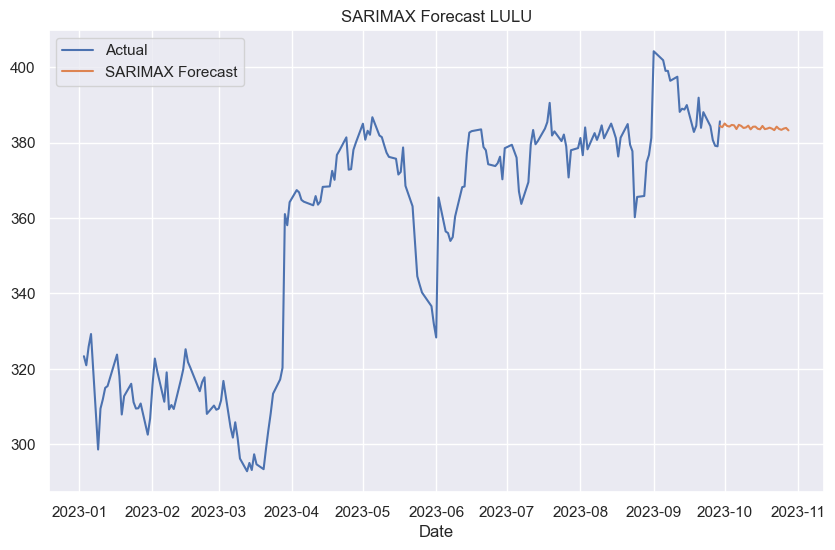

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(stock_price_lulu['Close'], label='Actual')
plt.plot(sarimax_forecast_lulu, label='SARIMAX Forecast')
plt.title('SARIMAX Forecast LULU')
plt.xlabel('Date')
plt.legend()
plt.show()

## SARIMAX For SKX

In [75]:
stock_skx = 'SKX'
start_skx = datetime.datetime(2023, 1, 1)
end_skx = datetime.datetime(2023, 10, 1)
stock_price_skx = yf.download(stock_skx, start=start_skx, end=end_skx, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [76]:
stock_price_skx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,42.419998,42.549999,41.540001,41.830002,41.830002,1550600
2023-01-04,42.380001,43.939999,42.200001,43.450001,43.450001,1858500
2023-01-05,42.810001,43.549999,42.070000,43.220001,43.220001,1360700
2023-01-06,44.060001,44.730000,43.580002,44.590000,44.590000,1612000
2023-01-09,44.529999,46.049999,43.970001,45.779999,45.779999,2245800


In [77]:
skx_filtered = stock_price_skx[['Open', 'High', 'Low', 'Volume']]
X_skx = skx_filtered
y_skx = stock_price_skx['Close']

In [78]:
train_len_skx = int(len(stock_price_skx) * 0.8)
X_train_skx, y_train_skx = X_skx[:train_len_skx], y_skx[:train_len_skx]
X_test_skx, y_test_skx = X_skx[train_len_skx:], y_skx[train_len_skx:]

In [79]:
sarimax_2 = SARIMAX(y_train_skx, exog=X_train_skx, order=(8, 1, 8))
sarimax_2_results = sarimax_2.fit(disp=0)

In [80]:
start_skx_1 = len(X_train_skx)
end_skx_1 = len(X_train_skx) + len(X_test_skx) -1

In [81]:
sarimax_pred_skx = sarimax_2_results.predict(start_skx_1, end_skx_1, exog=X_test_skx)
sarimax_pred_skx.index = X_test_skx.index

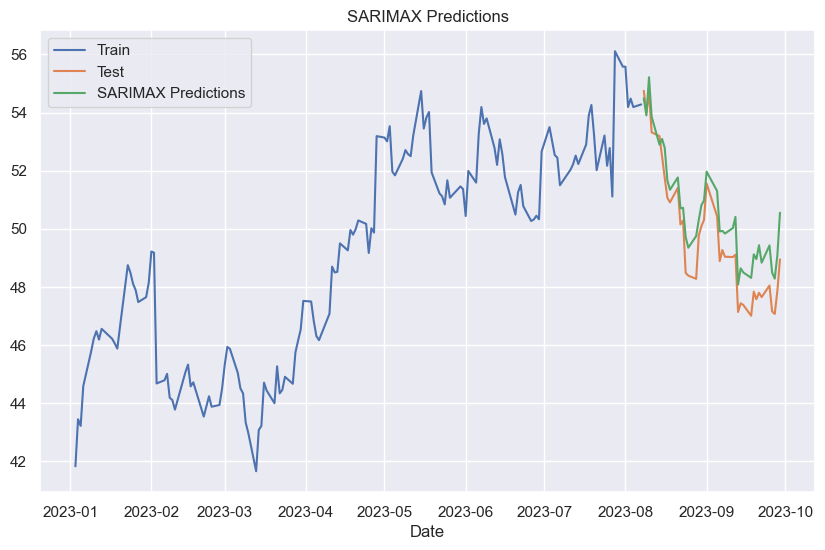

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(y_train_skx, label='Train')
plt.plot(y_test_skx, label='Test')
plt.plot(sarimax_pred_skx, label='SARIMAX Predictions')
plt.title('SARIMAX Predictions')
plt.xlabel('Date')
plt.legend()
plt.show()

In [83]:
mae_sarimax_skx = mean_absolute_error(y_test_skx, sarimax_pred_skx)
mse_sarimax_skx = mean_squared_error(y_test_skx, sarimax_pred_skx)
rmse_sarimax_skx = np.sqrt(mean_squared_error(y_test_skx, sarimax_pred_skx))

In [84]:
print("Mean Absolute Error (MAE):", mae_sarimax_skx)
print("Mean Squared Error (MSE):", mse_sarimax_skx)
print("Root Mean Squared Error (RMSE):", rmse_sarimax_skx)

Mean Absolute Error (MAE): 0.9007191914655167
Mean Squared Error (MSE): 0.9770557395648289
Root Mean Squared Error (RMSE): 0.9884612989717043


In [85]:
sarimax_model_skx = SARIMAX(y_skx, order=(8, 1, 8))
sarimax_result_skx = sarimax_model_skx.fit(disp=0)

In [86]:
sarimax_forecast_skx = sarimax_result_skx.forecast(steps=30, exog=X_test_skx.iloc[-30:])
forecast_index_skx = pd.date_range(y.index[-1], periods=30)
sarimax_forecast_skx.index = forecast_index_skx

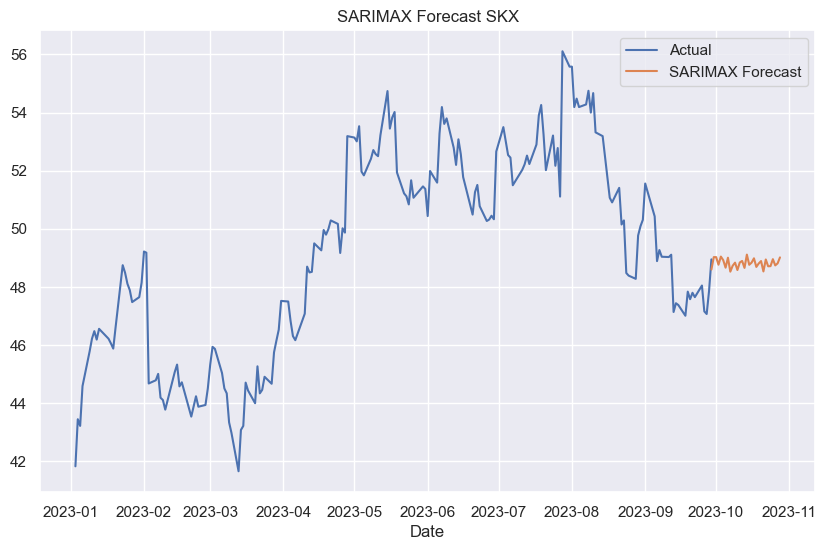

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(stock_price_skx['Close'], label='Actual')
plt.plot(sarimax_forecast_skx, label='SARIMAX Forecast')
plt.title('SARIMAX Forecast SKX')
plt.xlabel('Date')
plt.legend()
plt.show()